#Importing libraries


In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd 
import lightgbm as lgb
from tqdm import tqdm
from datetime import datetime
import gc
import math
from fastai.tabular import *
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, StratifiedKFold
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import datetime
from tqdm import tqdm_notebook

%matplotlib inline

**Loading datasets from my drive using gdown:**

In [2]:
!gdown https://drive.google.com/uc?id=1xTlto7tbQijeajjwBMFpBso-jfRsbHya
!unzip /content/layerai-air-quality-prediction-challenge.zip

Downloading...
From: https://drive.google.com/uc?id=1xTlto7tbQijeajjwBMFpBso-jfRsbHya
To: /content/layerai-air-quality-prediction-challenge.zip
100% 4.47M/4.47M [00:00<00:00, 153MB/s]
Archive:  /content/layerai-air-quality-prediction-challenge.zip
  inflating: SampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


**Reading the datasets:**

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub  = pd.read_csv('SampleSubmission.csv')

In [4]:
train.shape, test.shape, sub.shape

((9923, 71), (4254, 70), (4254, 2))

#Feature engineering


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9923 entries, 0 to 9922
Data columns (total 71 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID                                                        9923 non-null   object 
 1   date                                                      9923 non-null   object 
 2   device                                                    9923 non-null   object 
 3   site_latitude                                             9923 non-null   float64
 4   site_longitude                                            9923 non-null   float64
 5   humidity                                                  9923 non-null   float64
 6   temp_mean                                                 9903 non-null   float64
 7   SulphurDioxide_SO2_column_number_density                  4291 non-null   float64
 8   SulphurDioxide_SO2

In [6]:
train.describe()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
count,9923.000000,9923.000000,9923.000000,9903.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,4291.000000,...,8414.000000,8414.000000,8414.000000,8414.000000,8414.000000,8414.000000,8414.000000,8414.000000,8414.000000,9923.000000
mean,0.242512,32.472012,0.790819,21.571340,0.000025,0.791470,0.000014,0.146898,-17.585282,37.885657,...,6334.871458,56017.987582,5405.379477,17.943963,0.269046,-17.784138,40.689597,-86.994058,27.792085,57.107307
std,0.332311,0.545655,0.157910,4.060502,0.000299,0.197640,0.000207,0.085867,86.751706,19.323026,...,3172.279161,19694.711846,3073.159743,33.709480,0.052252,86.453994,19.073526,40.091767,6.905511,27.482947
min,-1.244985,29.989236,0.000000,0.000000,-0.000996,0.345894,-0.000671,0.000000,-105.713519,0.100934,...,1150.149929,15003.535156,1150.149929,1.250367,0.012392,-106.727040,0.101032,-160.284790,8.387497,1.160400
25%,0.289040,32.553714,0.770865,21.233081,-0.000149,0.659173,-0.000117,0.084368,-99.640536,22.521445,...,3948.409668,39480.238281,2952.133894,4.790914,0.240371,-99.612631,26.535263,-126.529379,23.377410,38.028288
50%,0.315446,32.589580,0.822951,22.271875,0.000010,0.785107,0.000009,0.148113,-97.301544,42.489365,...,5768.341064,57283.976562,4768.781361,6.774909,0.267970,-97.295380,45.016811,-85.782608,28.024277,51.930242
75%,0.354700,32.617600,0.869333,23.314268,0.000182,0.906811,0.000139,0.216913,73.653023,55.985201,...,8665.129820,71602.269531,7665.129820,14.080288,0.295240,72.932994,57.407260,-50.006933,32.795132,72.033125
max,0.391478,32.752570,1.000000,29.735000,0.001880,1.633184,0.002445,0.299840,84.742798,66.024800,...,15000.000287,88513.484375,14000.000268,250.000000,1.000000,84.802010,66.234421,-20.702782,41.993103,440.920000


In [7]:
test.describe()

,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,...,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle
count,4254.000000,4254.000000,4254.000000,4254.000000,914.000000,914.000000,914.000000,914.000000,914.000000,914.000000,...,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000,3739.000000
mean,0.271946,32.507890,0.797250,21.377984,0.000024,0.786688,0.000014,0.160708,-3.778465,41.072424,...,49741.018636,6269.296381,56096.222275,5293.169081,15.676498,0.260560,-13.308279,39.635118,-111.383869,28.603467
std,0.279129,0.455167,0.130349,3.319262,0.000294,0.163332,0.000220,0.089894,86.151048,18.217650,...,14539.760399,2419.497546,15692.221187,2385.060103,23.364321,0.052850,86.677696,19.075719,26.173745,6.934472
min,-1.244985,29.989236,0.000000,0.000000,-0.000906,0.407956,-0.000759,0.000000,-106.783440,0.183495,...,16141.984375,1161.950073,19083.507813,1161.950073,1.263446,0.019287,-106.808876,0.062084,-158.676987,12.138694
25%,0.298750,32.560322,0.782365,20.977431,-0.000163,0.695856,-0.000131,0.106139,-98.751070,24.899353,...,38024.841621,4442.553610,43132.918581,3459.379646,4.794175,0.229168,-99.012184,24.737008,-133.018314,23.870209
50%,0.319970,32.589580,0.822076,21.970833,-0.000019,0.787345,-0.000014,0.173614,71.555822,44.372217,...,50500.111547,5825.691895,57563.257813,4833.404297,7.587555,0.258294,-96.923509,44.056541,-115.978489,28.865322
75%,0.356400,32.615000,0.859951,22.756597,0.000199,0.866970,0.000154,0.233017,73.668476,56.691319,...,60011.927734,8052.403392,67732.875000,7052.403547,15.761735,0.292188,73.558815,57.048698,-91.778774,34.100858
max,0.391478,32.752570,0.986475,28.208333,0.001066,1.287140,0.000636,0.298424,76.750778,66.236806,...,88201.218750,13789.440430,88201.218750,12789.440430,215.000626,0.443467,88.739200,66.236592,-40.149767,41.821057


In [8]:
train.head()

,ID,date,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5
0,ID_JBYXJEUZ8X,2020-03-18,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,...,4181.792969,69589.453125,3181.793457,7.799846,0.278111,76.618553,9.970293,-93.110069,19.214193,63.853333
1,ID_PEJJNLBUPR,2019-10-13,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.507083
2,ID_21L8UZQO1T,2019-12-21,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,...,4440.391113,67341.109375,3440.390869,62.496590,0.416631,-97.300758,63.690605,-127.856804,40.857922,80.290833
3,ID_GNW2G8J4T8,2020-02-20,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.601687
4,ID_4XOX2V6SK0,2019-04-17,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,...,4842.057488,64347.788635,3842.057585,4.971117,0.277157,74.786025,32.583070,-57.273638,21.864529,89.642229


In [9]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [ ]:
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.week
train['day'] = train['date'].dt.day

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.week
test['day'] = test['date'].dt.day

In [11]:
train['total_days_month'] = train['month'].apply(lambda x: 31 if x==1 else (28+31 if x==2 else (28+31+31 if x==1 else 28+30+31+31))) 
train['total_days'] = train['total_days_month'] + train['day']

test['total_days_month'] = test['month'].apply(lambda x: 31 if x==1 else (28+31 if x==2 else (28+31+31 if x==1 else 28+30+31+31))) 
test['total_days'] = test['total_days_month'] + test['day']

In [12]:
train.drop('date', axis=1, inplace=True)
test.drop('date', axis=1, inplace=True)

In [13]:
corrmat = train.corr()
corrmat[corrmat['pm2_5']>0.2].pm2_5.index

Index(['CarbonMonoxide_CO_column_number_density',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density', 'pm2_5'],
      dtype='object')

In [14]:
def radian_conv(degree):
    """
    Return radian.
    """
    return  np.radians(degree) 
train['SulphurDioxide_sensor_azimuth_angle'] = radian_conv(train['SulphurDioxide_sensor_azimuth_angle'])
train['SulphurDioxide_sensor_zenith_angle'] = radian_conv(train['SulphurDioxide_sensor_zenith_angle'])
train['SulphurDioxide_solar_azimuth_angle'] = radian_conv(train['SulphurDioxide_solar_azimuth_angle'])
train['SulphurDioxide_solar_zenith_angle'] = radian_conv(train['SulphurDioxide_solar_zenith_angle'])

train['CarbonMonoxide_sensor_azimuth_angle'] = radian_conv(train['CarbonMonoxide_sensor_azimuth_angle'])
train['CarbonMonoxide_sensor_zenith_angle'] = radian_conv(train['CarbonMonoxide_sensor_zenith_angle'])
train['CarbonMonoxide_solar_azimuth_angle'] = radian_conv(train['CarbonMonoxide_solar_azimuth_angle'])
train['CarbonMonoxide_solar_zenith_angle'] = radian_conv(train['CarbonMonoxide_solar_zenith_angle'])

train['NitrogenDioxide_sensor_azimuth_angle'] = radian_conv(train['NitrogenDioxide_sensor_azimuth_angle'])
train['NitrogenDioxide_sensor_zenith_angle'] = radian_conv(train['NitrogenDioxide_sensor_zenith_angle'])
train['NitrogenDioxide_solar_azimuth_angle'] = radian_conv(train['NitrogenDioxide_solar_azimuth_angle'])
train['NitrogenDioxide_solar_zenith_angle'] = radian_conv(train['NitrogenDioxide_solar_zenith_angle'])

train['Formaldehyde_solar_zenith_angle'] = radian_conv(train['Formaldehyde_solar_zenith_angle'])
train['Formaldehyde_solar_azimuth_angle'] = radian_conv(train['Formaldehyde_solar_azimuth_angle'])
train['Formaldehyde_sensor_zenith_angle'] = radian_conv(train['Formaldehyde_sensor_zenith_angle'])
train['Formaldehyde_sensor_azimuth_angle'] = radian_conv(train['Formaldehyde_sensor_azimuth_angle'])

train['UvAerosolIndex_sensor_azimuth_angle'] = radian_conv(train['UvAerosolIndex_sensor_azimuth_angle'])
train['UvAerosolIndex_sensor_zenith_angle'] = radian_conv(train['UvAerosolIndex_sensor_zenith_angle'])
train['UvAerosolIndex_solar_azimuth_angle'] = radian_conv(train['UvAerosolIndex_solar_azimuth_angle'])
train['UvAerosolIndex_solar_zenith_angle'] = radian_conv(train['UvAerosolIndex_solar_zenith_angle'])

train['Ozone_sensor_azimuth_angle'] = radian_conv(train['Ozone_sensor_azimuth_angle'])
train['Ozone_sensor_zenith_angle'] = radian_conv(train['Ozone_sensor_zenith_angle'])
train['Ozone_solar_azimuth_angle'] = radian_conv(train['Ozone_solar_azimuth_angle'])
train['Ozone_solar_zenith_angle'] = radian_conv(train['Ozone_solar_zenith_angle'])

train['Cloud_sensor_azimuth_angle'] = radian_conv(train['Cloud_sensor_azimuth_angle'])
train['Cloud_sensor_zenith_angle'] = radian_conv(train['Cloud_sensor_zenith_angle'])
train['Cloud_solar_azimuth_angle'] = radian_conv(train['Cloud_solar_azimuth_angle'])
train['Cloud_solar_zenith_angle'] = radian_conv(train['Cloud_solar_zenith_angle'])


test['SulphurDioxide_sensor_azimuth_angle'] = radian_conv(test['SulphurDioxide_sensor_azimuth_angle'])
test['SulphurDioxide_sensor_zenith_angle'] = radian_conv(test['SulphurDioxide_sensor_zenith_angle'])
test['SulphurDioxide_solar_azimuth_angle'] = radian_conv(test['SulphurDioxide_solar_azimuth_angle'])
test['SulphurDioxide_solar_zenith_angle'] = radian_conv(test['SulphurDioxide_solar_zenith_angle'])

test['CarbonMonoxide_sensor_azimuth_angle'] = radian_conv(test['CarbonMonoxide_sensor_azimuth_angle'])
test['CarbonMonoxide_sensor_zenith_angle'] = radian_conv(test['CarbonMonoxide_sensor_zenith_angle'])
test['CarbonMonoxide_solar_azimuth_angle'] = radian_conv(test['CarbonMonoxide_solar_azimuth_angle'])
test['CarbonMonoxide_solar_zenith_angle'] = radian_conv(test['CarbonMonoxide_solar_zenith_angle'])

test['NitrogenDioxide_sensor_azimuth_angle'] = radian_conv(test['NitrogenDioxide_sensor_azimuth_angle'])
test['NitrogenDioxide_sensor_zenith_angle'] = radian_conv(test['NitrogenDioxide_sensor_zenith_angle'])
test['NitrogenDioxide_solar_azimuth_angle'] = radian_conv(test['NitrogenDioxide_solar_azimuth_angle'])
test['NitrogenDioxide_solar_zenith_angle'] = radian_conv(test['NitrogenDioxide_solar_zenith_angle'])

test['Formaldehyde_solar_zenith_angle'] = radian_conv(test['Formaldehyde_solar_zenith_angle'])
test['Formaldehyde_solar_azimuth_angle'] = radian_conv(test['Formaldehyde_solar_azimuth_angle'])
test['Formaldehyde_sensor_zenith_angle'] = radian_conv(test['Formaldehyde_sensor_zenith_angle'])
test['Formaldehyde_sensor_azimuth_angle'] = radian_conv(test['Formaldehyde_sensor_azimuth_angle'])

test['UvAerosolIndex_sensor_azimuth_angle'] = radian_conv(test['UvAerosolIndex_sensor_azimuth_angle'])
test['UvAerosolIndex_sensor_zenith_angle'] = radian_conv(test['UvAerosolIndex_sensor_zenith_angle'])
test['UvAerosolIndex_solar_azimuth_angle'] = radian_conv(test['UvAerosolIndex_solar_azimuth_angle'])
test['UvAerosolIndex_solar_zenith_angle'] = radian_conv(test['UvAerosolIndex_solar_zenith_angle'])

test['Ozone_sensor_azimuth_angle'] = radian_conv(test['Ozone_sensor_azimuth_angle'])
test['Ozone_sensor_zenith_angle'] = radian_conv(test['Ozone_sensor_zenith_angle'])
test['Ozone_solar_azimuth_angle'] = radian_conv(test['Ozone_solar_azimuth_angle'])
test['Ozone_solar_zenith_angle'] = radian_conv(test['Ozone_solar_zenith_angle'])

test['Cloud_sensor_azimuth_angle'] = radian_conv(test['Cloud_sensor_azimuth_angle'])
test['Cloud_sensor_zenith_angle'] = radian_conv(test['Cloud_sensor_zenith_angle'])
test['Cloud_solar_azimuth_angle'] = radian_conv(test['Cloud_solar_azimuth_angle'])
test['Cloud_solar_zenith_angle'] = radian_conv(test['Cloud_solar_zenith_angle'])

In [15]:
data=pd.concat([train,test],axis=0)
data.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,pm2_5,year,month,week,day,total_days_month,total_days
0,ID_JBYXJEUZ8X,ANQ16PZJ,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,0.174014,-1.625077,0.335351,63.853333,2020,3,12,18,120,138
1,ID_PEJJNLBUPR,AB6051M4,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,32.507083,2019,10,41,13,120,133
2,ID_21L8UZQO1T,A0WN66FH,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,1.111611,-2.231522,0.713105,80.290833,2019,12,51,21,120,141
3,ID_GNW2G8J4T8,aq_41,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,NaN,NaN,NaN,42.601687,2020,2,8,20,59,79
4,ID_4XOX2V6SK0,aq_41,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,0.568682,-0.999614,0.381608,89.642229,2019,4,16,17,120,137


In [16]:
data.shape

(14177, 76)

In [17]:
label_encoder =LabelEncoder() 
data['device']= label_encoder.fit_transform(data['device'])

In [18]:
a=[i for i in range(1,14178)]
data['num'] = a

In [19]:
def lag_feature(df, lags, col):
    tmp = df[['device','num',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['device','num',col+'_lag_'+str(i)]
        shifted['num'] += i
        df = pd.merge(df, shifted, on=['device','num'], how='left')
    return df

In [20]:
data = lag_feature(data, [1,2,3,4,5,6], 'SulphurDioxide_SO2_column_number_density_15km')
data = lag_feature(data, [1,2,3,30], 'SulphurDioxide_SO2_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'SulphurDioxide_SO2_column_number_density_amf')
data = lag_feature(data, [1,2,3,4,5,6,30], 'SulphurDioxide_SO2_slant_column_number_density')

data = lag_feature(data, [1,2,3,4,5,6,30], 'CarbonMonoxide_H2O_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'CarbonMonoxide_CO_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'CarbonMonoxide_cloud_height')
data = lag_feature(data, [10,20,30], 'CarbonMonoxide_sensor_altitude')

data = lag_feature(data, [1,2,3,30], 'NitrogenDioxide_NO2_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'NitrogenDioxide_NO2_slant_column_number_density')
data = lag_feature(data, [1,2,3,4,5,6,30], 'NitrogenDioxide_tropospheric_NO2_column_number_density')
data = lag_feature(data, [1,2,3,4,5,6,30], 'NitrogenDioxide_stratospheric_NO2_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'NitrogenDioxide_absorbing_aerosol_index')
data = lag_feature(data, [1,2,3,4,5,30], 'NitrogenDioxide_cloud_fraction')
data = lag_feature(data, [10,20,30], 'NitrogenDioxide_sensor_altitude')
data = lag_feature(data, [1,2,3,4,30], 'NitrogenDioxide_tropopause_pressure')

data = lag_feature(data, [1,2,3,4,5,30], 'Formaldehyde_HCHO_slant_column_number_density')
data = lag_feature(data, [1,2,3,4,5,6,30], 'Formaldehyde_tropospheric_HCHO_column_number_density')
data = lag_feature(data, [1,2,3,4,5,6,30], 'Formaldehyde_tropospheric_HCHO_column_number_density_amf')
data = lag_feature(data, [1,2,3,4,5,30], 'Formaldehyde_cloud_fraction')

data = lag_feature(data, [10,20,30], 'UvAerosolIndex_sensor_altitude')
data = lag_feature(data, [1,2,3,4,30], 'UvAerosolIndex_absorbing_aerosol_index')

data = lag_feature(data, [1,2,3,4,5,6], 'Ozone_O3_effective_temperature')
data = lag_feature(data, [1,2,3,30], 'Ozone_O3_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'Ozone_O3_column_number_density_amf')
data = lag_feature(data, [1,2,3,4,5,30], 'Ozone_O3_slant_column_number_density')
data = lag_feature(data, [1,2,3,4,5,30], 'Ozone_cloud_fraction')

data = lag_feature(data, [1,2,3,4,5,30], 'Cloud_cloud_fraction')
data = lag_feature(data, [1,2,3,4,5,30], 'Cloud_surface_albedo')
data = lag_feature(data, [1,2,3,4,5,30], 'Cloud_cloud_optical_depth')
data = lag_feature(data, [10,20,30], 'Cloud_cloud_base_height')
data = lag_feature(data, [10,20,30], 'Cloud_cloud_top_height')
data = lag_feature(data, [1,2,3,4,30], 'Cloud_cloud_base_pressure')
data = lag_feature(data, [1,2,3,4,5,30], 'Cloud_cloud_top_pressure')

In [21]:
data.head(3)

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,Cloud_cloud_base_pressure_lag_2,Cloud_cloud_base_pressure_lag_3,Cloud_cloud_base_pressure_lag_4,Cloud_cloud_base_pressure_lag_30,Cloud_cloud_top_pressure_lag_1,Cloud_cloud_top_pressure_lag_2,Cloud_cloud_top_pressure_lag_3,Cloud_cloud_top_pressure_lag_4,Cloud_cloud_top_pressure_lag_5,Cloud_cloud_top_pressure_lag_30
0,ID_JBYXJEUZ8X,5,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID_PEJJNLBUPR,2,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ID_21L8UZQO1T,0,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Center of the city



In [22]:
from geopy.geocoders import Nominatim
import time
from pprint import pprint

app = Nominatim(user_agent="tutorial")
# get location raw data
location = app.geocode("Kampala, Uganda").raw
# print raw data
pprint(location)

{'boundingbox': ['0.2143567', '0.4057676', '32.5098753', '32.6687413'],
 'class': 'boundary',
 'display_name': 'Kampala Capital City, Kampala, Central Region, Uganda',
 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png',
 'importance': 0.7925411725065692,
 'lat': '0.3177137',
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. '
            'https://osm.org/copyright',
 'lon': '32.5813539',
 'osm_id': 10546821,
 'osm_type': 'relation',
 'place_id': 283600301,
 'type': 'administrative'}


In [23]:
def add_center_feature(df):
    site_latitude = float(location['lat'])
    site_longitude = float(location['lon'])
    df['center_lat'] = [site_latitude] * df.shape[0]
    df['center_long'] = [site_longitude] * df.shape[0]
    return df

add_center_feature(data);

# Manhattan distnace


In [24]:
def manhattan_distance(lat, lon):
    a = np.abs(lat -lon)
    return a
data['manhattan_dist'] = manhattan_distance(data['site_latitude'].values, data['site_longitude'].values,)

# Bearing


In [25]:
def bearing_array(lat, lng):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lat - lng)
    lat, lng = map(np.radians, (lat, lng))
    y = np.sin(lng_delta_rad) * np.cos(lat)
    x = np.cos(lat) * np.sin(lat) - np.sin(lng) * np.cos(lng) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))
data['bearing'] = bearing_array(data['site_latitude'].values, data['site_longitude'].values,)
data.head()

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,Cloud_cloud_top_pressure_lag_1,Cloud_cloud_top_pressure_lag_2,Cloud_cloud_top_pressure_lag_3,Cloud_cloud_top_pressure_lag_4,Cloud_cloud_top_pressure_lag_5,Cloud_cloud_top_pressure_lag_30,center_lat,center_long,manhattan_dist,bearing
0,ID_JBYXJEUZ8X,5,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317714,32.581354,32.206858,-125.319438
1,ID_PEJJNLBUPR,2,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317714,32.581354,32.191516,-125.298847
2,ID_21L8UZQO1T,0,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317714,32.581354,32.292575,-125.321748
3,ID_GNW2G8J4T8,16,-1.244985,29.989236,0.919271,16.338542,-0.000111,0.750228,-0.000083,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317714,32.581354,31.234221,-127.087130
4,ID_4XOX2V6SK0,16,-1.244985,29.989236,0.858365,16.602083,-0.000127,0.792634,-0.000101,0.087338,...,NaN,NaN,NaN,NaN,NaN,NaN,0.317714,32.581354,31.234221,-127.087130


In [26]:
# covert features  fron string to List of values 
def replace_nan(x):
    if x=="nan":
        return np.nan
    else :
        return float(x)

In [27]:
features=["humidity","temp_mean"]

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [28]:
def aggregate_features(x,col_name):
    x["max_"+col_name]=x[col_name].apply(np.max)
    x["min_"+col_name]=x[col_name].apply(np.min)
    x["mean_"+col_name]=x[col_name].apply(np.mean)
    x["std_"+col_name]=x[col_name].apply(np.std)
    x["var_"+col_name]=x[col_name].apply(np.var)
    x["median_"+col_name]=x[col_name].apply(np.median)
    x["ptp_"+col_name]=x[col_name].apply(np.ptp)
    x["p1_"+col_name]=x[col_name].apply(percentile(1))
    x["p5_"+col_name]=x[col_name].apply(percentile(5))
    x["p10_"+col_name]=x[col_name].apply(percentile(10))
    x["p20_"+col_name]=x[col_name].apply(percentile(20))
    x["p30_"+col_name]=x[col_name].apply(percentile(30))
    x["p40_"+col_name]=x[col_name].apply(percentile(40))
    x["p60_"+col_name]=x[col_name].apply(percentile(60))
    x["p70_"+col_name]=x[col_name].apply(percentile(70))
    x["p80_"+col_name]=x[col_name].apply(percentile(80))
    x["p90_"+col_name]=x[col_name].apply(percentile(90))
    x["p95_"+col_name]=x[col_name].apply(percentile(95))
    x["p99_"+col_name]=x[col_name].apply(percentile(99))
    return x  
def remove_nan_values(x):
    return [e for e in x if not math.isnan(e)]

In [29]:
for col_name in tqdm(features):
    data=aggregate_features(data,col_name)

100%|██████████| 2/2 [00:45<00:00, 22.89s/it]


In [30]:
data.head(3)

,ID,device,site_latitude,site_longitude,humidity,temp_mean,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,...,p10_temp_mean,p20_temp_mean,p30_temp_mean,p40_temp_mean,p60_temp_mean,p70_temp_mean,p80_temp_mean,p90_temp_mean,p95_temp_mean,p99_temp_mean
0,ID_JBYXJEUZ8X,5,0.353465,32.560322,0.846844,22.038542,-0.000138,1.042629,-0.000143,0.291358,...,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542,22.038542
1,ID_PEJJNLBUPR,2,0.390741,32.582257,0.874493,21.545833,NaN,NaN,NaN,NaN,...,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833,21.545833
2,ID_21L8UZQO1T,0,0.285751,32.578325,0.729340,23.568655,NaN,NaN,NaN,NaN,...,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655,23.568655


In [31]:
train=data.iloc[:9923,:]
test=data.iloc[9923:,]

In [32]:
train.shape, test.shape

((9923, 305), (4254, 305))

In [33]:
test = test.drop(['pm2_5'], axis = 1)

In [34]:
train.shape, test.shape

((9923, 305), (4254, 304))

In [35]:
train.isnull().sum()

ID                 0
device             0
site_latitude      0
site_longitude     0
humidity           0
                  ..
p70_temp_mean     20
p80_temp_mean     20
p90_temp_mean     20
p95_temp_mean     20
p99_temp_mean     20
Length: 305, dtype: int64

##Get rid of "Highly Correlated Features":

In [36]:
features = train.columns

num_feature = [col for col in features if col not in ['ID','pm2_5','date','device']] 
drop_columns=[]
corr = train[num_feature].corr()
# Drop highly correlated features 
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.999 :
            if columns[j]:
                columns[j] = False
                print('FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(train[num_feature].columns[i] , train[num_feature].columns[j], corr.iloc[i,j]))
        elif corr.iloc[i,j] <= -0.995:
            if columns[j]:
                columns[j] = False

drop_columns = train[num_feature].columns[columns == False].values
print('drop_columns',len(drop_columns),drop_columns)

train.drop(drop_columns,inplace=True,axis =1 )
test.drop(drop_columns,inplace=True,axis =1 )

FEAT_A: site_longitude FEAT_B: bearing - Correlation: 0.9995057906894059
FEAT_A: humidity FEAT_B: max_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: min_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: mean_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: median_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p1_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p5_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p10_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p20_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p30_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p40_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p60_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p70_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p80_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p90_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p95_humidity - Correlation: 1.0
FEAT_A: humidity FEAT_B: p99_humidity - Correlation: 1.0
FEAT_A: temp_

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


**Get rid of constant features:**

In [37]:
features2 = train.columns

cols = [col for col in features2 if col not in ['ID','pm2_5','device']]

# Check and remove constant features
columns_to_drop = [feat for feat in train[cols] if train[feat].std() ==0]
columns_to_drop

['center_long',
 'std_humidity',
 'var_humidity',
 'ptp_humidity',
 'std_temp_mean',
 'var_temp_mean',
 'ptp_temp_mean']

In [ ]:
train.drop(columns = columns_to_drop, inplace = True)
test.drop(columns = columns_to_drop, inplace = True)

In [39]:
train.shape, test.shape

((9923, 56), (4254, 55))

In [42]:
test.columns

Index(['ID', 'device', 'site_latitude', 'site_longitude', 'humidity',
       'temp_mean', 'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_t

#Modeling


In [43]:
columns= ['device', 'site_latitude', 'site_longitude', 'humidity',
       'temp_mean', 'SulphurDioxide_SO2_column_number_density',
       'SulphurDioxide_SO2_column_number_density_amf',
       'SulphurDioxide_SO2_slant_column_number_density',
       'SulphurDioxide_cloud_fraction', 'SulphurDioxide_sensor_azimuth_angle',
       'SulphurDioxide_sensor_zenith_angle',
       'SulphurDioxide_solar_azimuth_angle',
       'SulphurDioxide_solar_zenith_angle',
       'SulphurDioxide_SO2_column_number_density_15km',
       'CarbonMonoxide_CO_column_number_density',
       'CarbonMonoxide_H2O_column_number_density',
       'CarbonMonoxide_cloud_height', 'CarbonMonoxide_sensor_altitude',
       'CarbonMonoxide_sensor_azimuth_angle',
       'NitrogenDioxide_NO2_column_number_density',
       'NitrogenDioxide_tropospheric_NO2_column_number_density',
       'NitrogenDioxide_stratospheric_NO2_column_number_density',
       'NitrogenDioxide_NO2_slant_column_number_density',
       'NitrogenDioxide_tropopause_pressure',
       'NitrogenDioxide_absorbing_aerosol_index',
       'NitrogenDioxide_cloud_fraction',
       'Formaldehyde_tropospheric_HCHO_column_number_density',
       'Formaldehyde_tropospheric_HCHO_column_number_density_amf',
       'Formaldehyde_HCHO_slant_column_number_density',
       'Formaldehyde_cloud_fraction', 'Ozone_O3_column_number_density',
       'Ozone_O3_column_number_density_amf',
       'Ozone_O3_slant_column_number_density',
       'Ozone_O3_effective_temperature', 'Ozone_cloud_fraction',
       'Cloud_cloud_fraction', 'Cloud_cloud_top_pressure',
       'Cloud_cloud_top_height', 'Cloud_cloud_base_pressure',
       'Cloud_cloud_base_height', 'Cloud_cloud_optical_depth',
       'Cloud_surface_albedo', 'year', 'month', 'week', 'day',
       'total_days_month', 'total_days', 'num',
       'SulphurDioxide_SO2_column_number_density_15km_lag_1',
       'CarbonMonoxide_CO_column_number_density_lag_1',
       'CarbonMonoxide_cloud_height_lag_1', 'center_lat', 'manhattan_dist']

In [45]:
params = {
    'objective' :'regression',
    'learning_rate' : 0.02,
    'num_iterations': 50000,     # #Note: To change num_iterations to 50000
    'max_bins': 50, 
    'max_depth' :7 ,
    'num_leaves' : 70,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': 'mae' ,
    'min_data_in_leaf':5,
    'reg_lambda' :100
}


train_set = lgb.Dataset(train[columns], train['pm2_5'], silent=False,categorical_feature=['year','month','day','week'])
valid_set = lgb.Dataset(train[columns], train['pm2_5'], silent=False,categorical_feature=['year','month','day','week'])
model = lgb.train(params, train_set = train_set, num_boost_round=10000,early_stopping_rounds=500,verbose_eval=500, valid_sets=valid_set)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[500]	valid_0's l1: 5.84502
[1000]	valid_0's l1: 4.51801
[1500]	valid_0's l1: 3.82411
[2000]	valid_0's l1: 3.31994
[2500]	valid_0's l1: 2.92339
[3000]	valid_0's l1: 2.60171
[3500]	valid_0's l1: 2.32788
[4000]	valid_0's l1: 2.09495
[4500]	valid_0's l1: 1.89634
[5000]	valid_0's l1: 1.72204
[5500]	valid_0's l1: 1.56931
[6000]	valid_0's l1: 1.43566
[6500]	valid_0's l1: 1.31393
[7000]	valid_0's l1: 1.20851
[7500]	valid_0's l1: 1.11211
[8000]	valid_0's l1: 1.0261
[8500]	valid_0's l1: 0.948632
[9000]	valid_0's l1: 0.878024
[9500]	valid_0's l1: 0.813029
[10000]	valid_0's l1: 0.752921
[10500]	valid_0's l1: 0.698779
[11000]	valid_0's l1: 0.648863
[11500]	valid_0's l1: 0.602809
[12000]	valid_0's l1: 0.560933
[12500]	valid_0's l1: 0.522709
[13000]	valid_0's l1: 0.487833
[13500]	valid_0's l1: 0.454593
[14000]	valid_0's l1: 0.424598
[14500]	valid_0's l1: 0.397595
[15000]	valid_0's l1: 0.371569
[15500]	valid_0's l1: 0.347297
[16000]	valid

In [46]:
prediction = model.predict(test[columns])
prediction

array([30.61089624, 71.60577103, 42.36008337, ..., 60.44466032,
       61.81574736, 22.97685969])

#plotting feature importance

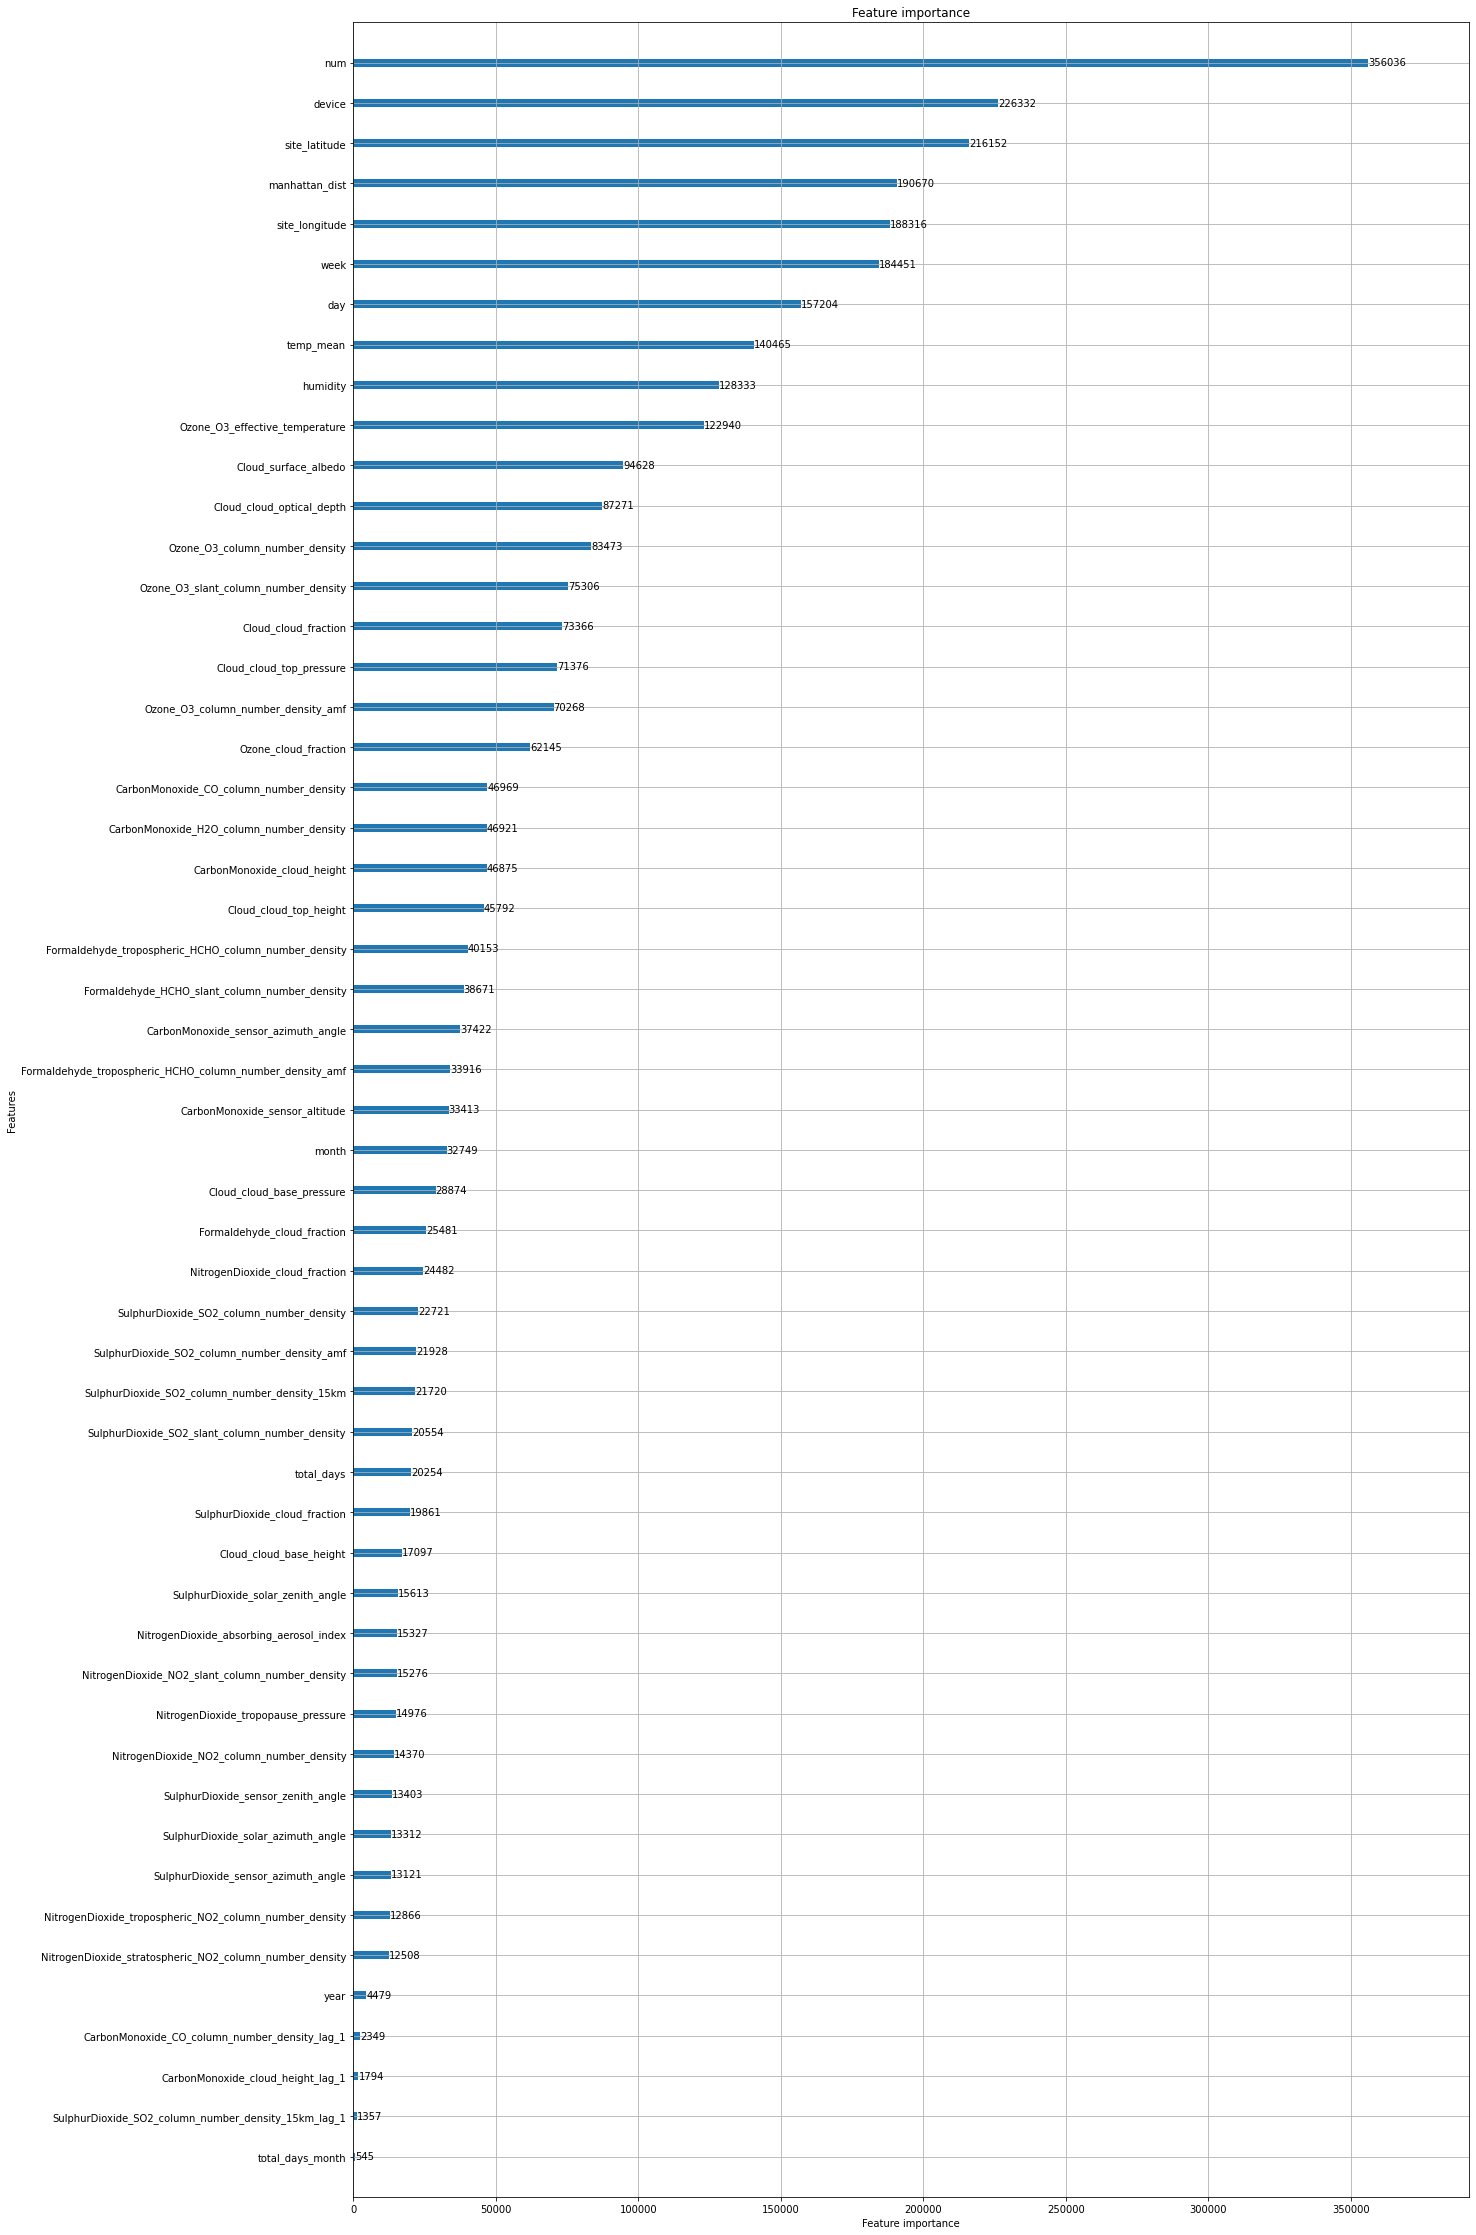

In [47]:
lgb.plot_importance(model, figsize=(20,40))
plt.show()

#Create Submission

In [49]:
submit = pd.DataFrame({'ID': test['ID'], 'pm2_5': prediction})
from IPython.display import FileLink
def create_submission(submission_file, submission_name):
    submission_file.to_csv(submission_name+".csv" , index=False)
    return FileLink(submission_name+".csv")
create_submission(submit, 'sub_layer.ai_lgb')

submit.head()

/content/sub_layer.ai_lgb.csv

,ID,pm2_5
9923,ID_UOH62J0XHX,30.610896
9924,ID_4OPWSB0UHJ,71.605771
9925,ID_3SLMNNG1Z3,42.360083
9926,ID_MFUHTXYPM4,77.127061
9927,ID_TY1DAND8ZP,93.221251
